# Predicting house prices with neural networks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Data

### loading the data

In [2]:
raw_data = pd.read_csv("data/train.csv")
raw_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
raw_data.shape

(1460, 81)

### Extracting the numeric columns

In [4]:
raw_data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [5]:
numeric_columns = list(raw_data.columns[(raw_data.dtypes==np.int64) |
                 (raw_data.dtypes==np.float64)])
print(numeric_columns, "\n", len(numeric_columns))

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'] 
 38


Set `SalesPrice` as the last index, since it is the value we want to predict.

In [6]:
numeric_columns.remove('SalePrice')
numeric_columns.append('SalePrice')

We do not need the `Id` column.

In [7]:
numeric_columns.remove('Id')

Now we extract the numeric data.

In [8]:
numeric_data = raw_data[numeric_columns]
numeric_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


Now let's deal with the missing values in the data.

In [9]:
nan_columns = np.any(pd.isna(numeric_data), axis = 0)
nan_columns = list(nan_columns[nan_columns == True].index)
nan_columns

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

We simply replace them with zero.

In [10]:
numeric_data['LotFrontage'] = numeric_data['LotFrontage'].fillna(0)
numeric_data['MasVnrArea'] = numeric_data['MasVnrArea'].fillna(0)
numeric_data['GarageYrBlt'] = numeric_data['GarageYrBlt'].fillna(0)

/home/ahmad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ahmad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ahmad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


let's split the data for training and test!

In [16]:
from sklearn.model_selection import train_test_split
numeric_data_train, numeric_data_test = train_test_split(numeric_data, test_size=0.1)

### Normalizing the data
Before training our linear regression model, we have to normalize the data. We do this by subtracting each column from its minimum value and then dividing it by the difference between maximum and minimum.

In [18]:
# saving max, min for each column
maxs, mins = dict(), dict()

In [19]:
for col in numeric_data:
    maxs[col] = numeric_data_train[col].max()
    mins[col] = numeric_data_train[col].min()

In [20]:
numeric_data_train = (numeric_data_train - numeric_data_train.min()) / (numeric_data_train.max() - numeric_data_train.min())

## Building a Linear Regression model

In [21]:
import torch
import torch.nn as nn

In [22]:
numeric_x_columns = list(numeric_data_train.columns)
numeric_x_columns.remove("SalePrice")
X_train_df = numeric_data_train[numeric_x_columns]
y_train_df = pd.DataFrame(numeric_data_train["SalePrice"])

Now we have to convert the data into torch tensors. A `torch.Tensor` is a multi-dimensional matrix containing elements of a single data type. It's very similar to arrays in `NumPy`.

In [23]:
X_train = torch.tensor(X_train_df.values, dtype=torch.float)
y_train = torch.tensor(y_train_df.values, dtype=torch.float)

In [24]:
print(X_train.size(), y_train.size())

torch.Size([1314, 36]) torch.Size([1314, 1])


### Defining a model with pytorch
A model is always defined as a class in pytorch. It should have a `__init__` function in which you define the layers of your network. It also should have a `forward` function (method) that basically defines the forward pass on the network.

For the beggining, let's start with a single layer network.

In [25]:
class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        y_pred = self.activation(self.linear1(x))
        y_pred = self.linear2(y_pred)
        return y_pred

In [27]:
D_in, D_out = X_train.shape[1], y_train.shape[1]

In [28]:
# defining the first model: an instance of the class "Net"
model1 = Net(D_in, 500, D_out)

The next steps is to define the __loss criterion__ and the __optimizer__ for the network. That is, we have to define the loss function we want to optimize during training and also the optimization method we are going to use, e.g, SGD, etc.

In [29]:
# MSE loss
criterion = nn.MSELoss(reduction='sum')
# SGD optimizer for finding the weights of the network
optimizer = torch.optim.SGD(model1.parameters(), lr=1e-4)

Now, we are ready to do the training. We can simply do this by a for loop over the number of iterations. The training has 3 main steps:
- A forward pass to compute the prediction for the current data point (batch).
- computing the loss for the current prediction.
- A backward pass to compute the gradient of the loss with respect to the weight of the network.
- Finaly, updating the weights of the network (`optimizer.step()`).

Note that in each backward pass pytorch saves the gradient for all of the parameters. Therefore it is important to replace the old gradient values with zero in the beggining of each iteration, otherwise the gradients will be accumulated during the iterations!

In [30]:
losses1 = []

for t in range(500):
    y_pred = model1(X_train)
    
    loss = criterion(y_pred, y_train)
    print(t, loss.item())
    losses1.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 212.12074279785156
1 1904.125
2 13151.103515625
3 1848.936279296875
4 133.611572265625
5 74.94303131103516
6 49.6674690246582
7 37.99897766113281
8 32.24648666381836
9 29.167255401611328
10 27.332897186279297
11 26.08904266357422
12 25.13568687438965
13 24.330886840820312
14 23.608631134033203
15 22.93484115600586
16 22.296741485595703
17 21.68573570251465
18 21.097606658935547
19 20.52947998046875
20 19.97885513305664
21 19.446849822998047
22 18.932147979736328
23 18.434091567993164
24 17.950437545776367
25 17.481311798095703
26 17.026901245117188
27 16.586393356323242
28 16.159038543701172
29 15.744958877563477
30 15.343223571777344
31 14.954510688781738
32 14.578536033630371
33 14.214092254638672
34 13.861385345458984
35 13.519657135009766
36 13.188273429870605
37 12.867388725280762
38 12.557364463806152
39 12.25770378112793
40 11.968367576599121
41 11.689340591430664
42 11.42078971862793
43 11.16317367553711
44 10.915022850036621
45 10.676183700561523
46 10.446859359741211
47 10.

430 3.3386363983154297
431 3.336292266845703
432 3.333953380584717
433 3.331620693206787
434 3.3292765617370605
435 3.32694411277771
436 3.3246235847473145
437 3.3223109245300293
438 3.320004940032959
439 3.3177084922790527
440 3.315420150756836
441 3.313142776489258
442 3.310872793197632
443 3.308605194091797
444 3.306349992752075
445 3.3041012287139893
446 3.301853656768799
447 3.2996232509613037
448 3.2973949909210205
449 3.2951607704162598
450 3.292935609817505
451 3.290714740753174
452 3.2884888648986816
453 3.2862679958343506
454 3.284053325653076
455 3.281841516494751
456 3.2796311378479004
457 3.277431011199951
458 3.27522611618042
459 3.273031234741211
460 3.27085280418396
461 3.2686657905578613
462 3.266489028930664
463 3.264322280883789
464 3.262155055999756
465 3.2599997520446777
466 3.2578492164611816
467 3.25569486618042
468 3.253571033477783
469 3.251431941986084
470 3.249295234680176
471 3.2471845149993896
472 3.2450716495513916
473 3.2429637908935547
474 3.240869998931

Now let's try a new model with more neurons in the hidden layer.

In [31]:
model2 = Net(D_in, 1000, D_out)

In [32]:
# MSE loss
criterion = nn.MSELoss(reduction='sum')
# SGD optimizer for finding the weights of the network
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-4)

In [33]:
losses2 = []

for t in range(500):
    y_pred = model2(X_train)
    
    loss = criterion(y_pred, y_train)
    print(t, loss.item())
    losses2.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 132.76609802246094
1 4904.0068359375
2 131057.3125
3 6154.6884765625
4 2856.466552734375
5 1520.4168701171875
6 821.390380859375
7 449.6463623046875
8 250.7775421142578
9 144.0603485107422
10 86.67938995361328
11 55.77344512939453
12 39.09730529785156
13 30.076574325561523
14 25.176441192626953
15 22.495473861694336
16 21.010234832763672
17 20.169645309448242
18 19.67672348022461
19 19.371776580810547
20 19.168611526489258
21 19.020845413208008
22 18.903308868408203
23 18.802547454833984
24 18.71117401123047
25 18.625205993652344
26 18.54237174987793
27 18.46154022216797
28 18.382234573364258
29 18.304237365722656
30 18.22711753845215
31 18.150726318359375
32 18.075117111206055
33 18.000028610229492
34 17.925151824951172
35 17.850730895996094
36 17.77680778503418
37 17.703367233276367
38 17.630416870117188
39 17.557992935180664
40 17.48587989807129
41 17.413753509521484
42 17.34189224243164
43 17.270355224609375
44 17.198863983154297
45 17.127490997314453
46 17.05658531188965
47 16.9

394 3.5810110569000244
395 3.5786592960357666
396 3.5763165950775146
397 3.5739827156066895
398 3.5716607570648193
399 3.569352865219116
400 3.5670506954193115
401 3.5647592544555664
402 3.5624656677246094
403 3.5601792335510254
404 3.557905673980713
405 3.5556492805480957
406 3.553406238555908
407 3.5511701107025146
408 3.548945188522339
409 3.546731948852539
410 3.5445258617401123
411 3.542330741882324
412 3.5401382446289062
413 3.5379528999328613
414 3.535778522491455
415 3.5336124897003174
416 3.531431198120117
417 3.529247522354126
418 3.527067184448242
419 3.5249016284942627
420 3.5227463245391846
421 3.5206246376037598
422 3.5185070037841797
423 3.516395092010498
424 3.514291286468506
425 3.5121939182281494
426 3.5101053714752197
427 3.5080199241638184
428 3.5059375762939453
429 3.5038580894470215
430 3.50178861618042
431 3.499723434448242
432 3.497662305831909
433 3.4956088066101074
434 3.4935622215270996
435 3.4915175437927246
436 3.4894776344299316
437 3.4874415397644043
438 

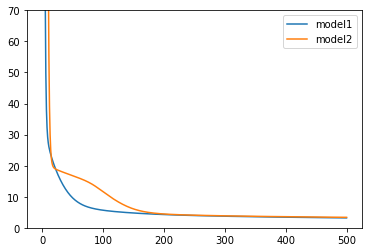

In [34]:
plt.plot(losses1, label="model1")
plt.plot(losses2, label="model2")
plt.ylim([0, 70])
plt.legend()

Let's compare the MSE loss on the test data

In [35]:
# we need to normalize the test data with the min and max value
# from the training data
for col in numeric_data_test.columns:
    numeric_data_test[col] = (numeric_data_test[col] - mins[col]) / (maxs[col] - mins[col])

/home/ahmad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [37]:
y_test_df = pd.DataFrame(numeric_data_test["SalePrice"])
y_test = torch.tensor(y_test_df.values, dtype=torch.float)
x_test_df = numeric_data_test[numeric_x_columns]
x_test = torch.tensor(x_test_df.values, dtype=torch.float)
# prediction for model 1
model1_pred = model1(x_test)
print("MSE loss for model1: ", criterion(model1_pred, y_test))
# prediction for model 2
model2_pred = model2(x_test)
print("MSE loss for model2: ", criterion(model2_pred, y_test))


MSE loss for model1:  tensor(0.2574, grad_fn=<MseLossBackward>)
MSE loss for model2:  tensor(0.3145, grad_fn=<MseLossBackward>)


## Now it is your turn!
### Exercises

1- Let's get back to model1. This time try to train it with a new optimizer. Try the Adam optimizer (which has shown to be faster than SGD for non-convex functions) and compare the trainig loss curve with SGD. Plot the training loss for the model trained with SGD and Adam optimizer.

Note1: Use `torch.optim.Adam(model1.parameters(), lr=...)`

Note2: If you are interested, check [this nice post](https://ruder.io/optimizing-gradient-descent/index.html) on differen gradient descent optimization algorithms.

2- This time we want to build a new model with a new architecture. Specifically, we want to train a network with 3 hidden layers on the data. You can use the following code to build the architecture. Use the values 500, 1000, 200 for H1, H2, and H3 respectively. Train this new network on the same training data and compare it with the model1 we built above.

```
class Net_new(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net_new, self).__init__()

        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)

    def forward(self, x):
        y_pred = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(y_pred).clamp(min=0)
        y_pred = self.linear3(y_pred).clamp(min=0)
        y_pred = self.linear4(y_pred)
        return y_pred
```